# Clasificación de Células Sanguíneas

En el proceso de diagnóstico de enfermedades, el estudio de la cantidad de células sanguíneas juega un papel importante para determinar factores que explican una enfermedad. En esta tarea, la idea es implementar el modelo de deep-learning más efectivo posible para clasificar células sanguíneas. Las clases de células sanguíneas son: [Eosinophil, Lymphocyte, Monocyte, Neutrophil]

In [28]:
#Instalamos el paquete gdown para poder descargar el dataset desde el gdrive
# !pip install gdown

In [29]:
#Descargamos el dataset
# import gdown
# output = 'blood.zip'
# gdown.download(id='1CUQjT45tJmqNv_p2HcDkr4Z-IDQEbRg3', output=output, quiet=False)

In [30]:
# Descomprimimos el dataset
# !unzip blood.zip

Implementa la mejor red neuronal posible. Tú decides si usas una red creada por ti mismo o si empleas transfer-learning. Entrena la red con los datos en la carpeta "TRAIN" y usa los datos en "VAL" como validación.

Para medir el performance final, realiza las inferencias sobre los datos del conjunto "TEST" y computa el accuracy sobre el conjunto de test. El accuracy es la proporción de imágenes para las cuales la predicción es correcta. IMPORTANTE: el accuracy de test se calcula una sola vez cuando hayas finalizado todos tus experimentos. Para tomar decisiones sobre el modelo y sus hiperparámetros solo puedes usar el conjunto de entrenamiento y validación.

Detalla todos los experimentos que hiciste y cómo llegaste a la mejor red neuronal reportada. Discute los resultados, comparando los distintos experimentos que tomaste en cuenta y responde a la pregunta: Porqué tu modelo final fue el mejor de todo lo que probaste?

IMPORTANTE: Evita el overfitting a toda costa. Un modelo con overfitting es aquel que durante el entrenamiento las curvas de loss/accuracy para datos de entrenamiento y validación se separan considerablemente. 

Éxitos!

## Implementación

Alumnos:
+ Daniel Carmona G.
+ Consuelo Rojas N.

In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import numpy as np
import random
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
import time
import os
import copy
import sys
import copy
from torch.optim import lr_scheduler

from torchvision.io import read_image
from PIL import Image
from sklearn.metrics import confusion_matrix
from time import perf_counter

import seaborn as sn
from sklearn.metrics import accuracy_score

torch.cuda.empty_cache()

In [32]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Cargar Datos

Parte importante es la estandarización de los datos. Para eso es necesario tener la desviación estandar y media de los datos de entrenamiento. Para luego, al crear los dataloader para entrenar el modelo. Esta estandarización se aplica a todos los datos por igual y depende tanto de la red a útilizar como de los datos.

In [33]:
def norm_std(dataloader):

  mean        = 0
  std         = 0
  nb_samples  = 0

  for data,y in dataloader:
    batch_samples = data.size(0)
    data = data.view(batch_samples, data.size(1), -1)
    mean += data.mean(2).sum(0)
    std += data.std(2).sum(0)
    nb_samples += batch_samples

  mean /= nb_samples
  std /= nb_samples
  return mean,std

In [34]:
# creating Location of data: train, validation, test
data='./images/'
batch_size_train = 32
batch_size_test = 32 

train_path=os.path.join(data,'TRAIN')
valid_path=os.path.join(data,'VAL')
test_path=os.path.join(data,'TEST')

In [35]:
datafile=datasets.ImageFolder(train_path,transform=transforms.Compose([transforms.Resize(size=(224,224)), transforms.ToTensor()]))
normalizationset = torch.utils.data.DataLoader(datafile,batch_size_train,shuffle=True)

In [36]:
mean, std = norm_std(normalizationset)

## Dataloaders

Para crear los dataloader, se genera un diccionario de transformaciones, en donde la gran mayoría solo corresponde al resize necesario de las imágenes. Esto se debe a que, usualmente, las redes tienen un tamaño mínimo y óptimo para su funcionamiento. Junto a este Resize, se hace la normalización, con las medidas de tendencia central sacadas anteriormente. Finalmente, se hace un ToTensor, para que los datos sean tensores de Pytorch y así se puedan entrenar las redes neuronales.

Para el conjunto con Data Augmentation, se agregan otro tipo de transformaciones a las imágenes, con el fin de aumentar su variabilidad y obtener más datos para poder entrenar el modelo. 

In [37]:
#transformers 
img_size = 224

data_transforms = {
    'TRAIN':
    transforms.Compose([
        transforms.Resize(size=(img_size,img_size)), 
        transforms.ToTensor(),
        transforms.Normalize(mean,std)#[0.6788, 0.6414, 0.6606], [0.2580, 0.2576, 0.2550]), 
        ]),
      
    'TRAIN_AUG': 
    transforms.Compose([
          transforms.ColorJitter(),
          transforms.RandomHorizontalFlip(),
          #transforms.RandomRotation(10),
          transforms.Resize(size=(img_size,img_size)),
          transforms.ToTensor(),
          transforms.Normalize(mean,std)#[0.6788, 0.6414, 0.6606], [0.2580, 0.2576, 0.2550]),
      ]),

    'VAL':
    transforms.Compose([
        transforms.Resize(size=(img_size,img_size)),
        transforms.ToTensor(),
        ]),

    'TEST':
    transforms.Compose([
        transforms.Resize(size=(img_size,img_size)),
        transforms.ToTensor(),
        ]),
     }

In [38]:
# creating Datasets to each of  folder created in prev
train_file = datasets.ImageFolder(train_path,transform=data_transforms['TRAIN'])
trainAug_file = datasets.ImageFolder(train_path,transform=data_transforms['TRAIN_AUG'])
trainAug_file = torch.utils.data.ConcatDataset([train_file,trainAug_file])
valid_file = datasets.ImageFolder(valid_path,transform=data_transforms['VAL'])
test_file = datasets.ImageFolder(test_path,transform=data_transforms['TEST'])


#Creating loaders for the dataset
dataloaders={
    'train':torch.utils.data.DataLoader(dataset=train_file,
                                        batch_size=batch_size_train,
                                        shuffle=True),
    'train_aug': torch.utils.data.DataLoader(dataset=trainAug_file,
                                        batch_size=batch_size_train,
                                        shuffle=True),
    'val':torch.utils.data.DataLoader(dataset=valid_file,
                                        batch_size=batch_size_train,
                                        shuffle=True),
    'test': torch.utils.data.DataLoader(dataset=test_file,
                                        batch_size=batch_size_test,
                                        shuffle=True)
}

# Funciones

Se crean funciones útiles para hacer la prueba de modelos más eficiente. La primera es para entrenar el modelo, la cual recibe el modelo, el dataloader de entrenamiento, el dataloader de validación, el optimizador, la función de pérdida y la cantidad de épocas. Esta función entrena el modelo y retorna los valores de pérdida y accuracy para entrenamiento y validación.

Además, se crea una función para hacer las inferencias sobre el modelo. Esta función recibe el modelo, el dataloader de test y retorna el accuracy del modelo. Junto con graficar la matriz de confusión del modelo.

In [50]:
def predict(model, dataloader, plot_title):
  global device
  label_real = []
  pred_model = []
  model.eval()
  with torch.no_grad():
    for x,y in dataloader:
      inputs = x.to(device)
      labels = y.to(device)#.long()

      outputs= model(inputs)
      pred = outputs.argmax(1, keepdim=True) #torch.argmax(outputs, 1)

      label_real = np.concatenate((label_real, labels.cpu().numpy()), axis=None)
      pred_model = np.concatenate((pred_model, pred.cpu().numpy()), axis=None)
      # label_real = np.concatenate((label_real, labels.numpy()), axis=None)
      # pred_model = np.concatenate((pred_model, pred.numpy()), axis=None)
      
  CM = confusion_matrix(label_real, pred_model, normalize= 'true')
  plt.figure(figsize = (10,7))
  sn.heatmap(CM, annot=True)
  plt.xlabel("Predicción")
  plt.ylabel("Observación")
  plt.title(plot_title)

  accuracy = accuracy_score(label_real, pred_model, normalize=True)
  print(f'Accuracy: {accuracy}')
  return label_real, pred_model


def plot(validation,train, plot_title,y_label):
  plt.figure(figsize = (10,7))
  plt.plot(train, label='Train Loss')
  plt.plot(validation, label='Validation Loss')
  plt.legend()
  plt.xlabel('Epoch')
  plt.ylabel(y_label)
  plt.title(plot_title)

# Funciones Entrenamiento

In [40]:
def load_data(file_path, batch_size=32):
      data_path = datasets.ImageFolder(train_path,transform=data_transforms['TRAIN_AUG'])
      batchSize = batch_size  # por defecto 32
      dataloader_X= torch.utils.data.DataLoader(data_path, batch_size=batchSize)

      return dataloader_X

In [47]:
#Esta función permite inicializar todas las semillas de números pseudoaleatorios.
# Puedes usar esta función para resetear los generadores de números aleatorios
def iniciar_semillas():
  SEED = 1234

  random.seed(SEED)
  np.random.seed(SEED)
  torch.manual_seed(SEED)
  torch.cuda.manual_seed(SEED)
  torch.backends.cudnn.deterministic = True

#Función para computar el accuracy. Se asume que predicciones y etiquetas son tensores en el GPU
def calculate_accuracy(y_pred, y):
  top_pred = y_pred.argmax(1, keepdim=True)
  correct = top_pred.eq(y.view_as(top_pred)).sum()
  acc = correct.float()/y.shape[0]
  return acc

#Función para entrenar una época de un modelo. Recibe como parámetros
#     -model: una red neuronal
#     -iterator: un iterador de la data a usar para el entrenamiento (generalmente creado con un DataLoader)
#     -optimizer: el optimizador para el entrenamiento
#     -criterion: la función de loss
#     -device: dispositivo a usar para el entrenamiento
#
#Devuelve el loss promedio y el accuracy promedio de la época (promedio de todos los batches)
def train_one_epoch(model, iterator, optimizer, criterion, device):
  epoch_loss = 0
  epoch_acc = 0

  #We have to set the neural network in training mode. This is because during
  #training, we need gradients and complementary data to ease the computation  
  model.train()
  
  #Training loop
  for (x, y) in iterator:
    x = x.to(device) #Data
    y = y.long().to(device) #Labels
        
    optimizer.zero_grad() #Clean gradients
             
    y_pred = model(x) #Feed the network with data    
    loss = criterion(y_pred, y) #Compute the loss
       
    acc = calculate_accuracy(y_pred, y) #Compute the accuracy
        
    loss.backward() #Compute gradients    
    optimizer.step() #Apply update rules
        
    epoch_loss += loss.item()
    epoch_acc += acc.item()
        
  return epoch_loss / len(iterator), epoch_acc / len(iterator)

#Función que evalúa una red neuronal con un conjunto de datos de prueba. Recibe como parámetros
#     -model: una red neuronal
#     -iterator: un iterador de la data a usar para el entrenamiento (generalmente creado con un DataLoader)
#     -criterion: la función de loss
#     -device: dispositivo a usar para el entrenamiento
#Devuelve el loss promedio y el accuracy promedio de la época (promedio de todos los batches)
def evaluate(model, iterator, criterion, device):
  epoch_loss = 0
  epoch_acc = 0

  #We put the network in testing mode
  #In this mode, Pytorch doesn't use features only reserved for 
  #training (dropout for instance)    
  model.eval()
    
  with torch.no_grad(): #disable the autograd engine (save computation and memory)
        
    for (x, y) in iterator:
      x = x.to(device)
      y = y.long().to(device)

      y_pred= model(x)

      loss = criterion(y_pred, y)

      acc = calculate_accuracy(y_pred, y)

      epoch_loss += loss.item()
      epoch_acc += acc.item()
  return epoch_loss / len(iterator), epoch_acc / len(iterator)

#Calcula el tiempo transcurrido entre dos timestamps
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

#Esta función realiza el entrenamiento completo de una red. Recibe como parámetros:
#     -network: la red neuronal
#     -optimizer: el optimizador para entrenamiento
#     -train_loader: el dataloader de datos de entrenamiento
#     -tes_loader: el dataloader de datos de prueba
#     -name: nombre a usar para guardar en disco la red con el mejor accuracy

def train_complete(network, optimizer, train_loader, val_loader, test_loader, name, epoch=20, data_aug = False):
  
  #Se envían la red y la función de loss al GPU
  network = network.to(device)
  criterion = nn.CrossEntropyLoss()
  criterion = criterion.to(device)

  train_loss_array, train_acc_array = [], []
  valid_loss_array, valid_acc_array = [], []

  #Fijar el entrenamiento en 20 épocas siempre
  EPOCHS = epoch

  best_valid_acc = float('-inf')

  for epoch in range(EPOCHS):
    if data_aug == True:
      train_loader = load_data(train_path, 32)
    
    start_time = time.time()

    #Train + validation cycles  
    train_loss, train_acc = train_one_epoch(network, train_loader, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(network, val_loader, criterion, device)

    train_acc_array.append(train_acc)
    train_loss_array.append(train_loss)
    valid_acc_array.append(valid_acc)
    valid_loss_array.append(valid_loss)
    
    #Si encontramos un modelo con accuracy de validación mayor, lo guardamos
    if valid_acc > best_valid_acc:
     best_valid_acc = valid_acc
     torch.save(network.state_dict(), f'{name}.pt')
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
  
  #Cuando se termina el entrenamiento, cargamos el mejor modelo guardado y calculamos el accuracy de prueba
  network.load_state_dict(torch.load(f'{name}.pt'))

  val_loss , val_acc = evaluate(network, val_loader, criterion, device)
  print(f'Val Loss: {val_loss:.3f} | Mejor val acc: {val_acc*100:.2f}%')

  test_loss , test_acc = evaluate(network, test_loader, criterion, device)
  print(f'Test Loss: {test_loss:.3f} | Mejor test acc: {test_acc*100:.2f}%')
  return train_loss_array, train_acc_array, valid_loss_array, valid_acc_array

A continuación se tienen los modelos entrenados para la tarea. Se creo una clase ResidualBlock, que se útiliza como block residual final para la red residual ResNet34 y ResNet18. Esta última red, se utiliza para hacer el transfer learning. Se crea una red con 4 capas lineales, con 512, 256, 128 y 64 neuronas respectivamente. Finalmente, se crea una capa de salida con 4 neuronas, una por cada clase de célula sanguínea.

Se utiliza este tipo de red para: 
* Para evitar los problemas de "vanishing gradient" y "exploding gradient", que se presentan en las redes convolucionales.
* Para mitigar los problemas de degradación en la precisión que lleva a que el error de entrenamiento aumente con el número de capas.

Además, se útiliza una red pre-entrenada, con los pesos congelados, de manera de poder hacer transfer learning con la red. Esto se hace con el fin de que la red pueda aprender de los pesos de la red pre-entrenada y así, poder hacer inferencias más precisas con menores costos computacionales.



In [42]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

In [43]:
class ResNet34(nn.Module):
    def __init__(self, block, layers, num_classes = 10):
        super(ResNet34, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU())
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512, num_classes)
        
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

# Entrenamiento de Modelos

In [45]:
iniciar_semillas() # Se inicializan las semillas

Se crea el primer modelo, correspondiente a una ResNet34 conectada aun ResidualBlock y una capa lineal de 4 salidas, útilizada para la clasificación de las 4 clases de células sanguíneas. Se entrena el modelo con 10 épocas, con un learning rate de 0.001 y un momentum de 0.9. Se obtiene un accuracy de 0.68 en el conjunto de validación y un 0.48 en el de entrenamiento.

Notar que esto es inusual, dado que normalmente el accuracy de entrenamiento es mayor al de validación. Las posibles explicacione a esto son que los datos estan muy desbalanceados, lo que haría que el modelo se sobreajuste a las clases mayoritarias, o que el modelo no esté entrenando bien y necesite más tiempos para entrenar. Igualmente, se probó entrenando durante más épocas y esto no mejoró mayormente, lo que significa que los tiempos computacionales para que se obtenga el resultado esperado son muy altos.

In [21]:
network = ResNet34(ResidualBlock, [3, 4, 6, 3], num_classes=4) # Creas la red
optimizer = optim.Adam(network.parameters(), lr=1e-3) #Creas el optimizador
train_loss_array, train_acc_array, valid_loss_array, valid_acc_array = train_complete(network, optimizer, dataloaders['train'],dataloaders['val'],dataloaders['test'],'resnet34',25,True) 

Epoch: 01 | Epoch Time: 1m 9s
	Train Loss: 0.447 | Train Acc: 92.36%
	 Val. Loss: 6.989 |  Val. Acc: 76.04%
Epoch: 02 | Epoch Time: 1m 8s
	Train Loss: 0.864 | Train Acc: 83.36%
	 Val. Loss: 2.216 |  Val. Acc: 68.60%
Epoch: 03 | Epoch Time: 1m 9s
	Train Loss: 1.049 | Train Acc: 72.49%
	 Val. Loss: 2.915 |  Val. Acc: 68.60%
Epoch: 04 | Epoch Time: 1m 9s
	Train Loss: 0.667 | Train Acc: 84.08%
	 Val. Loss: 1.616 |  Val. Acc: 68.60%
Epoch: 05 | Epoch Time: 1m 9s
	Train Loss: 0.693 | Train Acc: 82.28%
	 Val. Loss: 3.536 |  Val. Acc: 72.32%
Epoch: 06 | Epoch Time: 1m 8s
	Train Loss: 0.980 | Train Acc: 69.80%
	 Val. Loss: 1.248 |  Val. Acc: 68.60%
Epoch: 07 | Epoch Time: 1m 8s
	Train Loss: 0.968 | Train Acc: 65.81%
	 Val. Loss: 2.825 |  Val. Acc: 57.44%
Epoch: 08 | Epoch Time: 1m 8s
	Train Loss: 1.211 | Train Acc: 52.93%
	 Val. Loss: 1.167 |  Val. Acc: 68.60%
Epoch: 09 | Epoch Time: 1m 8s
	Train Loss: 0.813 | Train Acc: 69.24%
	 Val. Loss: 12.130 |  Val. Acc: 68.60%
Epoch: 10 | Epoch Time: 1m 

Notar que al probar el modelo con el conjunto de test, se obtiene un accuracy de 0.25, lo que significa que el modelo esta muy mal entrenado. Esto se debe a que el modelo se sobreajustó a los datos de entrenamiento y no generalizó bien a los datos de validación. De hecho, este resultado es, cercano al de un "random guess" con clases balanceadas.

In [25]:
model = ResNet34(ResidualBlock, [3, 4, 6, 3], num_classes=4)
model.load_state_dict(torch.load(f'resnet34.pt'))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

test_loss , test_acc = evaluate(model, dataloaders['val'], criterion, device)
print(f'Val Loss: {test_loss:.3f} | Mejor val acc: {test_acc*100:.2f}%')

test_loss , test_acc = evaluate(model, dataloaders['test'], criterion, device)
print(f'Test Loss: {test_loss:.3f} | Mejor test acc: {test_acc*100:.2f}%')
#plot(model_ft_trained_sinDA[2], model_ft_trained_sinDA[1],'Curvas de Perdidad Modelo DenseNet121 sin Data Augmentation')

Val Loss: 11.715 | Mejor val acc: 61.16%
Test Loss: 20.145 | Mejor test acc: 25.08%


## ResNet18 Sin Data Augmentation

Para la red ResNet18, se entrena el modelo con 6 épocas, con un learning rate de 0.001 y un momentum de 0.9. Se obtiene como mejor resultado un accuracy de 0.82 en el conjunto de validación y de 0.99 en el de entrenamiento. Esta diferencia entre los accuracy de entrenamiento y validación es menor a la de la red ResNet34, lo que significa que el modelo no se sobreajustó tanto a los datos de entrenamiento.

Además, en este caso, se utilizó una red pre-entrenada con los pesos congelados (transfer learning). De este modo, se hizo fine tunning a la última capa de la red, la cual corresponde a una capa lineal clasificadora.

Podemos ver, que este experimento tuvo mejores resultados con menos tiempo de entrenamiento que la red anterior. Esto se debe a la utilización del transfer learning. Lo que le permitió a la red hacer inferencias más precisas con los datos actuales.

In [20]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 4)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# # Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

c:\Users\Daniel\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [41]:
train_loss_array, train_acc_array, valid_loss_array, valid_acc_array = train_complete(model_ft, optimizer_ft,dataloaders['train'],dataloaders['val'],dataloaders['test'],'resnet18', 6) 

Epoch: 01 | Epoch Time: 0m 41s
	Train Loss: 1.217 | Train Acc: 72.15%
	 Val. Loss: 1.132 |  Val. Acc: 29.32%
Epoch: 02 | Epoch Time: 0m 41s
	Train Loss: 0.094 | Train Acc: 96.69%
	 Val. Loss: 0.903 |  Val. Acc: 54.02%
Epoch: 03 | Epoch Time: 0m 41s
	Train Loss: 0.029 | Train Acc: 99.07%
	 Val. Loss: 0.626 |  Val. Acc: 75.89%
Epoch: 04 | Epoch Time: 0m 41s
	Train Loss: 0.013 | Train Acc: 99.73%
	 Val. Loss: 0.715 |  Val. Acc: 76.93%
Epoch: 05 | Epoch Time: 0m 41s
	Train Loss: 0.005 | Train Acc: 99.93%
	 Val. Loss: 0.611 |  Val. Acc: 82.74%
Epoch: 06 | Epoch Time: 0m 41s
	Train Loss: 0.003 | Train Acc: 99.95%
	 Val. Loss: 0.777 |  Val. Acc: 77.98%
Val Loss: 0.703 | Mejor test acc: 82.74%
Test Loss: 1.754 | Mejor test acc: 51.16%


Sobre los resultados. Se puede ver que estos tampoco son los más optimos. Nuevamente, se puede deber a la desproporcionalidad en las clases. Y si se ven las matrices de confusión, sobre todo la de test (segunda), se puede ver que la red esta claramente sesgada a la clase mayoritaria, la cual corresponde a las células sanguíneas normales. Esto se debe a que la red se sobreajustó a esta clase, por lo que no realizó bien la generalización de las otras clases. Tan así, que no logra clasificar ninguna célula correspondiente a la clase 2.

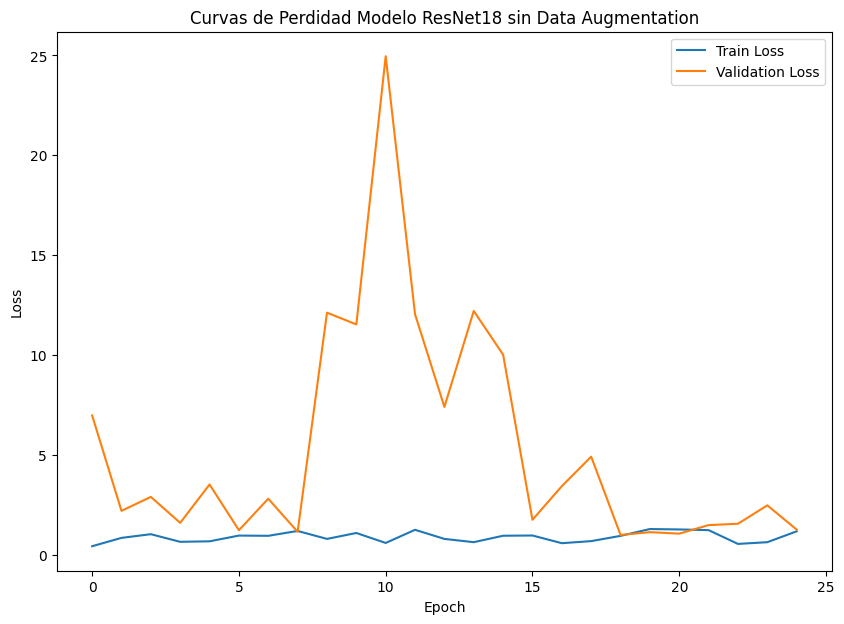

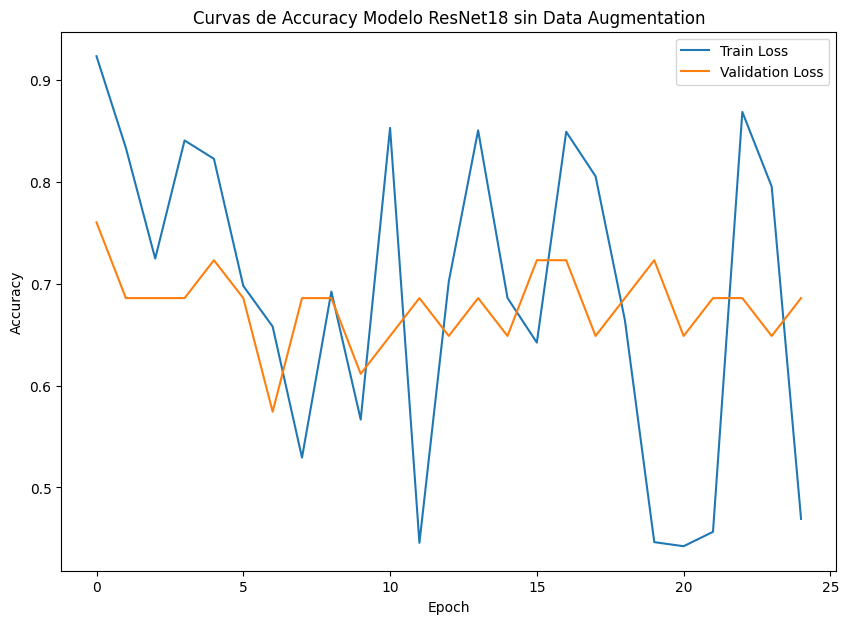

In [51]:
plot(valid_loss_array, train_loss_array,'Curvas de Perdidad Modelo ResNet18 sin Data Augmentation','Loss')
plot(valid_acc_array,train_acc_array,'Curvas de Accuracy Modelo ResNet18 sin Data Augmentation','Accuracy')

Accuracy: 0.7605633802816901
Accuracy: 0.45878568556493765


(array([0., 1., 2., ..., 0., 3., 3.]), array([3., 3., 3., ..., 0., 3., 3.]))

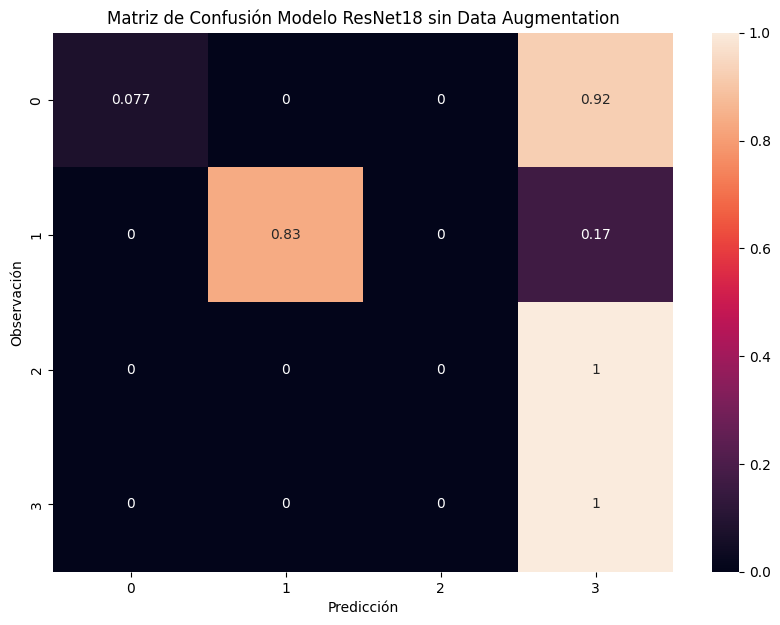

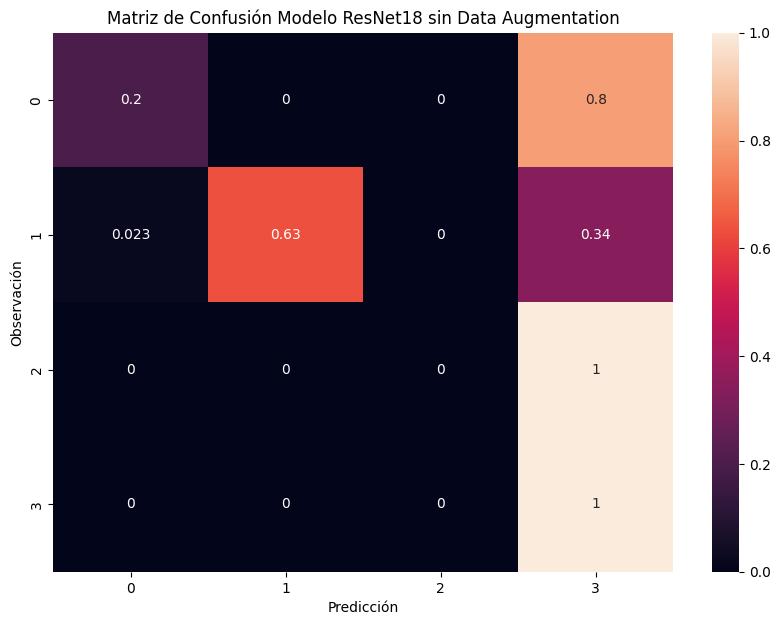

In [36]:
predict(model_ft, dataloaders['val'], 'Matriz de Confusión Modelo ResNet18 sin Data Augmentation')
predict(model_ft, dataloaders['test'], 'Matriz de Confusión Modelo ResNet18 sin Data Augmentation')

## ResNet18 Con Data Augmentation

Para el ultimo experimento se agrega data augmentation. Esto quiere decir que se agranda el set de datos de entrenamiento y se utiliza la misma red anterior, que fue la que dio mejores resultados con los datos normales.

Las transformaciones realizadas a los datos para aumentar su volumen fueron:
* Alteración de colores
* Reflexión horizontal

Además, se le agrega un factor de decaimiento al learning rate, de manera de que este disminuya con el tiempo. Esto se hace con el fin de que el modelo no se sobreajuste a los datos de entrenamiento y pueda generalizar mejor a los datos de validación.

In [46]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 4)

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=1e-3)
#optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

train_loss_array2, train_acc_array2, valid_loss_array2, valid_acc_array2 = train_complete(model_ft, optimizer_ft,dataloaders['train_aug'],dataloaders['val'],dataloaders['test'],'resnet18DA_v2',15)

c:\Users\Daniel\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 01 | Epoch Time: 1m 24s
	Train Loss: 0.151 | Train Acc: 94.30%
	 Val. Loss: 3.796 |  Val. Acc: 64.88%
Epoch: 02 | Epoch Time: 1m 24s
	Train Loss: 0.051 | Train Acc: 98.11%
	 Val. Loss: 5.513 |  Val. Acc: 68.60%
Epoch: 03 | Epoch Time: 1m 24s
	Train Loss: 0.039 | Train Acc: 98.74%
	 Val. Loss: 3.860 |  Val. Acc: 62.20%
Epoch: 04 | Epoch Time: 1m 25s
	Train Loss: 0.021 | Train Acc: 99.26%
	 Val. Loss: 3.640 |  Val. Acc: 76.04%
Epoch: 05 | Epoch Time: 1m 25s
	Train Loss: 0.035 | Train Acc: 98.94%
	 Val. Loss: 4.091 |  Val. Acc: 76.04%
Epoch: 06 | Epoch Time: 1m 24s
	Train Loss: 0.024 | Train Acc: 99.24%
	 Val. Loss: 3.819 |  Val. Acc: 64.88%
Epoch: 07 | Epoch Time: 1m 24s
	Train Loss: 0.013 | Train Acc: 99.55%
	 Val. Loss: 3.613 |  Val. Acc: 68.60%
Epoch: 08 | Epoch Time: 1m 24s
	Train Loss: 0.013 | Train Acc: 99.58%
	 Val. Loss: 8.086 |  Val. Acc: 68.60%
Epoch: 09 | Epoch Time: 1m 24s
	Train Loss: 0.026 | Train Acc: 99.20%
	 Val. Loss: 7.056 |  Val. Acc: 68.60%
Epoch: 10 | Epoch T

En los resultados, se puede ver que el accuracy de entrenamiento es de 0.99, mientras que el de validación es de 0.68. Esto dice que hay un sobreajustamiento a los datos de entrenamiento y una falta de generalización de los mismos. Además, los resultados con el dataset de prueba dan un accuracy de 0.28, siendo levemente mejores a un random guess. Esto demuestra que un data augmentation no es suficiente para mejorar los resultados de un modelo y puede hacer que una red baje su rendimiento.

Esto se puede explicar por una mala elección de las transformaciones realizadas a los datos y que al concatenar los datos hace que las brechas en desigualdad de datos se aumente, por lo que el modelo sigue reproduciendo el sesgo de las clases mayoritarias.

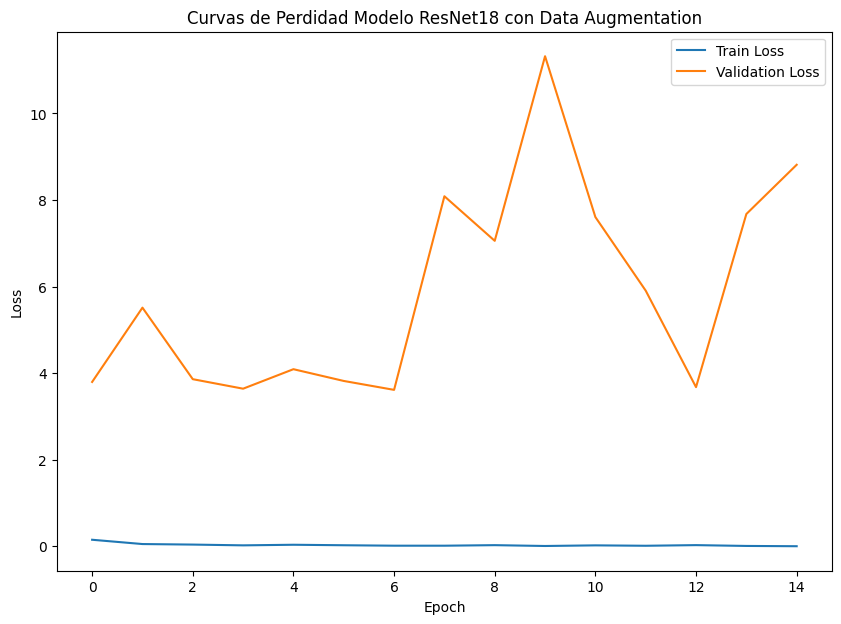

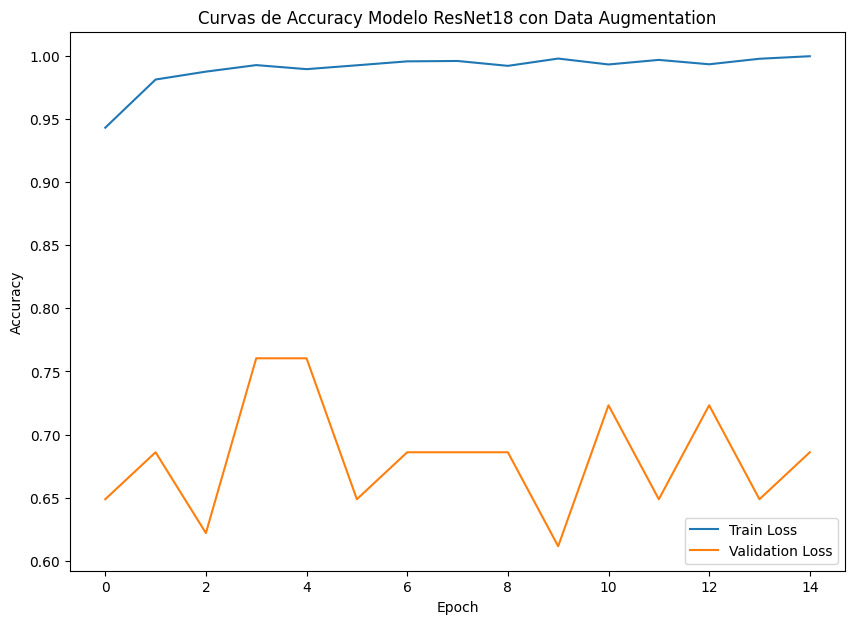

In [52]:
plot(valid_loss_array2, train_loss_array2,'Curvas de Perdidad Modelo ResNet18 con Data Augmentation','Loss')
plot(valid_acc_array2,train_acc_array2,'Curvas de Accuracy Modelo ResNet18 con Data Augmentation','Accuracy')

### Cargar Mejor Modelo Entrenado

Finalmente, se decide como mejor modelo una red ResNet18 pre-entrenada. Esta red presenta los mejores valores de accuracy tanto para el conjunto de entrenamiento como para el de validación. Lo mismo para el conjunto de prueba. 

Sin embargo, los resultados obtenidos no son los mejores, ya que al final el accuracy del conjunto de prueba es de un 50%, lo que significa que la generalización de las clases fue mala y si ven las matrices de confusión del modelo, se puede ver que la red solo aprendió a reconocer dos tipos de células y no las 4.

In [55]:
model2 = models.resnet18(pretrained=True)
num_ftrs = model2.fc.in_features
model2.fc = nn.Linear(num_ftrs, 4)
model2.load_state_dict(torch.load(f'resnet18.pt'))
model2 = model2.to(device)

criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

test_loss , test_acc = evaluate(model2, dataloaders['val'], criterion, device)
print(f'Val Loss: {test_loss:.3f} | Mejor val acc: {test_acc*100:.2f}%')

test_loss , test_acc = evaluate(model2, dataloaders['test'], criterion, device)
print(f'Test Loss: {test_loss:.3f} | Mejor test acc: {test_acc*100:.2f}%')

Val Loss: 0.596 | Mejor val acc: 79.02%
Test Loss: 1.751 | Mejor test acc: 51.22%


Posibles maneras de mejorar los resultados son:
* Aumentar el volumen de datos de entrenamiento, pero solo de las clases deficientes o balancear las clases. De manera de disminuir la brecha entre las clases y con esto que la red genere sesgos.
* Investigar más sobre los optimizadores y los learning rates, ya que estos son los que más afectan el rendimiento de la red y ayudan a evitar el sobreajuste de las mismas. Además, se puede generar una función que detenga el entrenamiento cuando el accuracy de validación empiece a empeorar mientras el de entrenamiento mejora, dado que este es un indicio de sobreajuste de la red.
* Probar con otras redes pre-entrenadas, como VGG16, VGG19, InceptionV3, etc. Y ver si estas dan mejores resultados que la ResNet18, ya que estas estan pre-entrenadas sobre otros datasets y pueden ser más precisas para el caso de uso actual. Es importante ver la documentación de las arquitecturas a utilizar, ya que cada una tiene sus propias características y se debe ver si estas se adaptan al problema actual.